In [1]:
from os import mkdir
from os.path import exists
from sys import exc_info
import itertools as itr
import random as rnd
import numpy as np
import keras.optimizers as opt
import keras.backend as K
import keras.callbacks as clb
import keras.models as mdl
import keras.layers as lyr
import keras.losses as lss
from keras.utils.generic_utils import CustomObjectScope
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
NUM_STEPS = 20

In [3]:
class Prime:
    @staticmethod
    def prime(a):
        return not (a < 2 or any(a % x == 0 for x in range(2, int(a**0.5) + 1)))
    
    @staticmethod
    def primes_below(n):
        return [i for i in range(n) if Prime.prime(i)]
    
    @staticmethod
    def __primes():
        a = 1
        while True:
            if Prime.prime(a):
                yield a
            a += 1
    
    @staticmethod
    def primes(n):
        return [i for i in itr.islice(Prime.__primes(), 0, n)]

print(Prime.prime(3))
print(Prime.prime(4))
print(Prime.primes_below(10))
print(Prime.primes(10))

True
False
[2, 3, 5, 7]
[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]


In [4]:
class Data:
    @staticmethod
    def make_data(n):
        if n <= NUM_STEPS:
            raise RuntimeError('引数には' + str(NUM_STEPS) + 'より大きい値を指定してください。')
        raw_data = [int(Prime.prime(i)) for i in range(1, n+1)]
        onehot_data = np.eye(2)[[i for i in raw_data]]
        t_inputs, t_targets = [], []
        
        for i in range(len(raw_data) - NUM_STEPS):
            t_inputs.append(raw_data[i : i + NUM_STEPS])
            t_targets.append(onehot_data[i + NUM_STEPS])
        
        inputs = np.array(t_inputs).reshape(len(t_inputs), NUM_STEPS, 1)
        targets = np.array(t_targets)
        
        return inputs, targets

x, y = Data.make_data(201)
#print(x)
#print(y)
print(np.shape(x))
print(np.shape(y))

(181, 20, 1)
(181, 2)


In [5]:
class Model:
    # モデル保存先
    modeldir = './data'
    modelfile = './data/Model3.h5'
    
    # モデルに関するパラメータ
#    number_of_layer = 15
    units = 25
    
    optimizer = opt.Adam()
#    activation = K.sin
    
    # 訓練に関するパラメータ
    batch_size = 200
    epochs = 200
    
    callbacks = []
    
    min_delta = 0
    patience = 5
    early_stopping = clb.EarlyStopping(monitor='val_loss'
                                       , min_delta=min_delta
                                       , patience=patience
                                       , mode='auto')
    callbacks.append(early_stopping)
    
#    base_lr = 1e-3
#    lr_decay_rate = 1 / 3
#    lr_steps = 4
#    lr_calc = lambda ep: float(
#        base_lr * lr_decay_rate ** (ep * lr_steps // epochs))
#    learning_rate_scheduler = clb.LearningRateScheduler(lr_calc)
#    callbacks.append(learning_rate_scheduler)
    
    factor = 0.5
    verbose = 1
    reduce_lr_on_plateau = clb.ReduceLROnPlateau(factor=factor,
                                                 verbose=verbose)
    callbacks.append(reduce_lr_on_plateau)
    
    validation_split = 0.1
    
    # モデルの初期化
    def __init__(self, recycle=True):
        if recycle:
            if exists(Model.modelfile):
                try:
                    print('訓練済みモデルを読み込みます。')
                    with CustomObjectScope({'sin': K.sin, 'cos': K.cos}):
                        self.__model = mdl.load_model(Model.modelfile)
                    self.__istrained = True
                    print('訓練済みモデルを読み込みました。')
                    return None
                except:
                    print('訓練済みモデルの読み込み中にエラーが発生しました。')
                    print('Unexpected error:', exc_info()[0])
                    raise
            else:
                print('訓練済みモデルが存在しません。')
        
        print('空のモデルを作成します。')
        self.__model = mdl.Sequential()
        self.__istrained = False
        print('空のモデルを作成しました。訓練を行ってください。')
    
    # 訓練
    def train(self, inputs, targets):
        if self.__istrained:
            raise RuntimeError('このモデルは既に訓練済みです。')
        
        print('訓練を行うので、お待ちください。')
        print('学習が頭打ちになった場合、途中で訓練を打ち切ります。')
        
        # モデルの実装
        self.__model.add(lyr.LSTM(Model.units))
#        for i in (range(Model.number_of_layer)):
#            self.__model.add(lyr.Dense(Model.units, activation=Model.activation))
        self.__model.add(lyr.Dense(targets.shape[1], activation=K.softmax))
        self.__model.compile(loss=lss.categorical_crossentropy, optimizer=Model.optimizer)
        
        # 訓練実施
        hist = self.__model.fit(inputs, targets
#                                , validation_data=validation_data
                                , batch_size=Model.batch_size
                                , epochs=Model.epochs
                                , callbacks=Model.callbacks
                                , validation_split=Model.validation_split
                               )
        self.__istrained = True
        
        # 訓練状況の可視化
        loss = hist.history['loss']
        val_loss = hist.history['val_loss']
        
        plt.figure()
        plt.plot(range(1, len(loss) + 1),
                 loss, marker='.', label='訓練データ')
        plt.plot(range(1, len(val_loss) + 1),
                 val_loss, marker='.', label='テストデータ')
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('エポック')
        plt.ylabel('損失')
        plt.yscale('log')
        plt.grid(which='major',color='black',linestyle='-')
        plt.grid(which='minor',color='black',linestyle='-')
        plt.show()
        
        # モデルの保存
        if not exists(Model.modeldir):
            try:
                mkdir(Model.modeldir)
            except:
                print('モデル保存フォルダの作成中にエラーが発生しました。')
                print('Unexpected error:', exc_info()[0])
                raise
        try:
            self.__model.save(Model.modelfile)
        except:
            print('モデルの保存中にエラーが発生しました。')
            print('Unexpected error:', exc_info()[0])
            raise
    
    # 予測
    def predict(self, inputs):
        if self.__istrained:
            return self.__model.predict(inputs)
        else:
            raise RuntimeError('モデルが訓練されていません。先に訓練を行ってください。')

In [6]:
class MyPrime:
    def __init__(self, model):
        self.__model = model
    
    def primes_below(self, n):
        if n <= NUM_STEPS:
            return Prime.primes_below(n)
        
        numbers = range(1, n)
        initial = [int(Prime.prime(i)) for i in range(1, NUM_STEPS+1)]
        t_inputs = np.array(initial)
        answer = Prime.primes_below(NUM_STEPS)
        
        for i in range(NUM_STEPS, n):
            inputs = t_inputs.reshape(1, NUM_STEPS, 1)
            prds = self.__model.predict(inputs) [0]
            prd = prds.argmax()
            np.delete(t_inputs, 0)
            np.append(t_inputs, prd)
            if prd == 1:
                answer.append(numbers[i-1])
        
        return answer

In [7]:
class PrimeChecker:
    @staticmethod
    def plot(x, answer):
        collect_answer = [Prime.prime(i) for i in x]
        plt.figure()
        plt.plot(x, collect_answer, marker='.', label='実際')
        plt.plot(x, answer, marker='.', label='予測', alpha=0.5)
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('primality')
        plt.show()
    
    @staticmethod
    def check(x, answer):
        collect_answer = [Prime.prime(i) for i in x]
        return np.sum(np.array(answer) == np.array(collect_answer)) / len(x)

空のモデルを作成します。
空のモデルを作成しました。訓練を行ってください。
訓練を行うので、お待ちください。
学習が頭打ちになった場合、途中で訓練を打ち切ります。
Train on 17982 samples, validate on 1998 samples
Epoch 1/200
17982/17982 [==============================] - 2s 129us/step - loss: 0.4487 - val_loss: 0.3252
Epoch 2/200
17982/17982 [==============================] - 2s 89us/step - loss: 0.3542 - val_loss: 0.3217
Epoch 3/200
17982/17982 [==============================] - 2s 88us/step - loss: 0.3529 - val_loss: 0.3209
Epoch 4/200
17982/17982 [==============================] - 2s 88us/step - loss: 0.3506 - val_loss: 0.3211
Epoch 5/200
17982/17982 [==============================] - 2s 85us/step - loss: 0.3484 - val_loss: 0.3205
Epoch 6/200
17982/17982 [==============================] - 2s 89us/step - loss: 0.3469 - val_loss: 0.3185
Epoch 7/200
17982/17982 [==============================] - 2s 88us/step - loss: 0.3451 - val_loss: 0.3174
Epoch 8/200
17982/17982 [==============================] - 2s 90us/step - loss: 0.3433 - val_loss: 0.3160
Epoch 9/200
17982/17

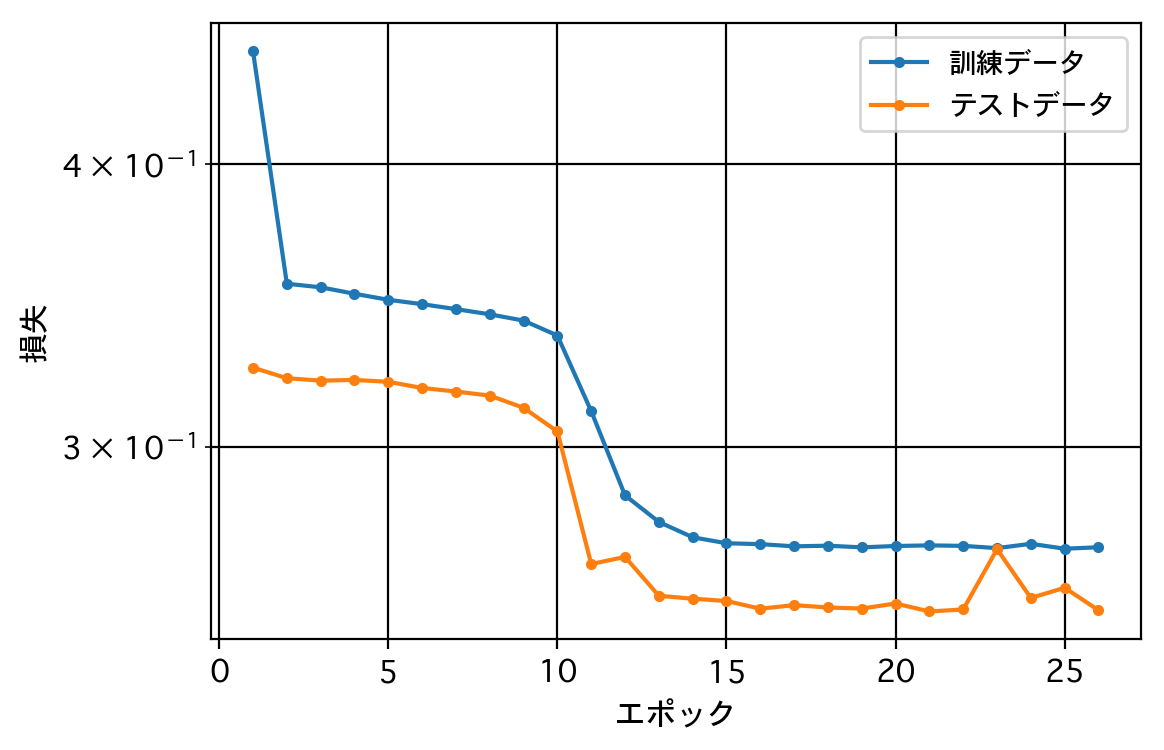

[2, 3, 5, 7, 11, 13, 17, 19]
[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
[0.9055163  0.09448373]
[0.9055163  0.09448373]
[0.9055163  0.09448373]
[0.9055163  0.09448373]
[0.9055163  0.09448373]
[0.9055163  0.09448373]
[0.9055163  0.09448373]
[0.9055163  0.09448373]


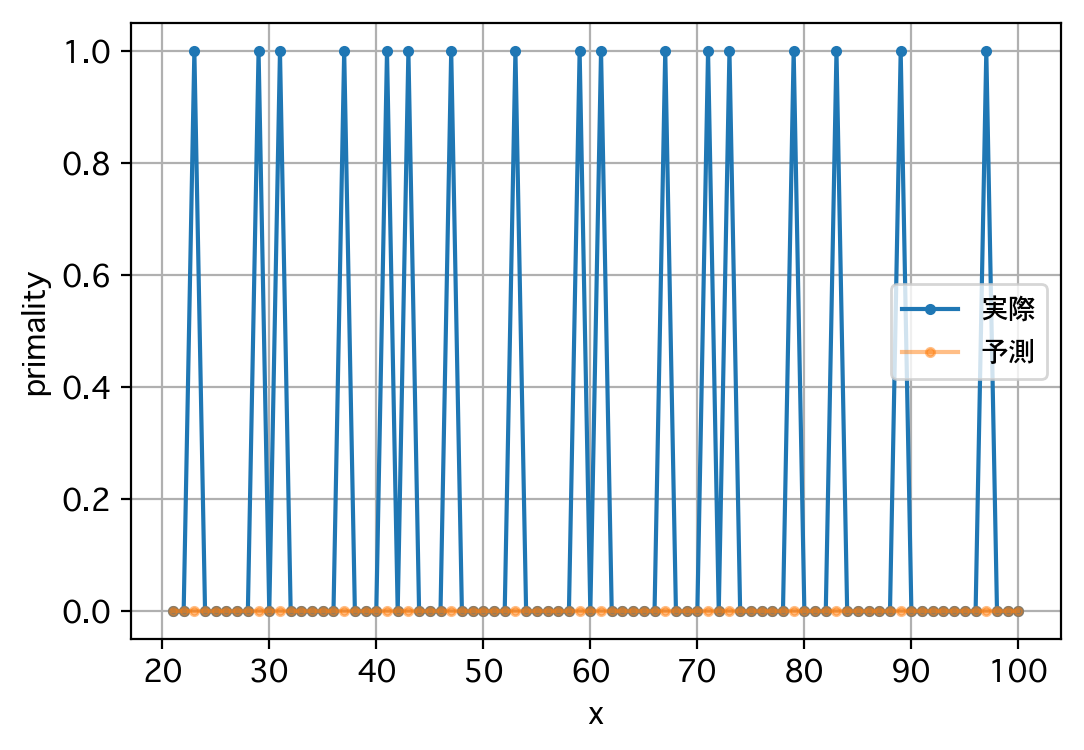

21〜100までの正答率：0.7875


In [8]:
inputs, targets = Data.make_data(20000)

m = Model(recycle=False)
#m = Model(recycle=True)
m.train(inputs, targets)

pr = MyPrime(m)

num = 100
print(pr.primes_below(num))
print(Prime.primes_below(num))

x = range(NUM_STEPS+1, num+1)
initial = [int(Prime.prime(i)) for i in range(1, NUM_STEPS+1)]
t_inputs = np.array(initial)
ans = [int(Prime.prime(i)) for i in range(1, NUM_STEPS+1)]
for i in range(NUM_STEPS, num):
    inputs = t_inputs.reshape(1, NUM_STEPS, 1)
    prds = m.predict(inputs) [0]
    if i % 10 == 0:
        print(prds)
    prd = prds.argmax()
    np.delete(t_inputs, 0)
    np.append(t_inputs, prd)
    ans.append(round(prd))
ans = ans[NUM_STEPS:num+1]

PrimeChecker.plot(x, ans)
print('21〜100までの正答率：' + str(PrimeChecker.check(x, ans)))